In [18]:
import requests, pandas as pd, numpy as np
from io import StringIO
import time, json
from datetime import date
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import matplotlib.pylab as plt
plt.rcParams['figure.figsize'] = 15, 6

In [19]:
df_fx_data = pd.read_csv(r'C:\Users\ADMIN\Desktop\WFH_HOL\CSV\BOE-XUDLERD.csv')
df_fx_data

,Date,Value
0,2017-11-09,0.8603
1,2017-11-08,0.8631
2,2017-11-07,0.8639
3,2017-11-06,0.8631
4,2017-11-03,0.8608
...,...,...
10832,1975-01-08,0.7554
10833,1975-01-07,0.7510
10834,1975-01-06,0.7524
10835,1975-01-03,0.7585


In [20]:
df_fx_data['Date'] = pd.to_datetime(df_fx_data['Date'])
indexed_df = df_fx_data.set_index('Date')
ts = indexed_df['Value']
ts.head(5)

Date
2017-11-09    0.8603
2017-11-08    0.8631
2017-11-07    0.8639
2017-11-06    0.8631
2017-11-03    0.8608
Name: Value, dtype: float64

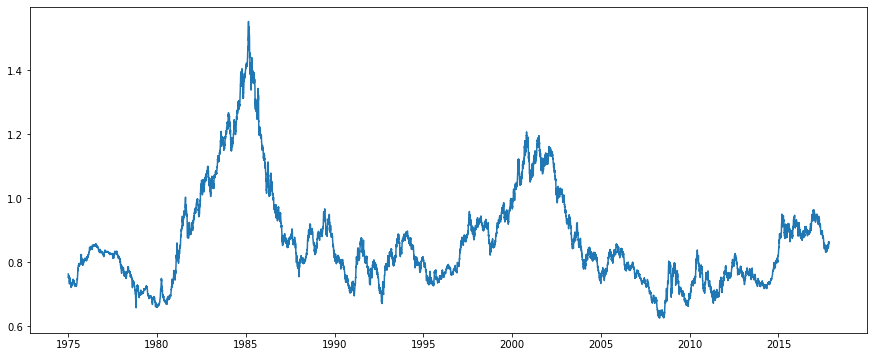

In [21]:
plt.plot(ts)

Date
1975-01-05    0.76090
1975-01-12    0.75346
1975-01-19    0.75546
1975-01-26    0.74388
1975-02-02    0.73902
Freq: W-SUN, Name: Value, dtype: float64


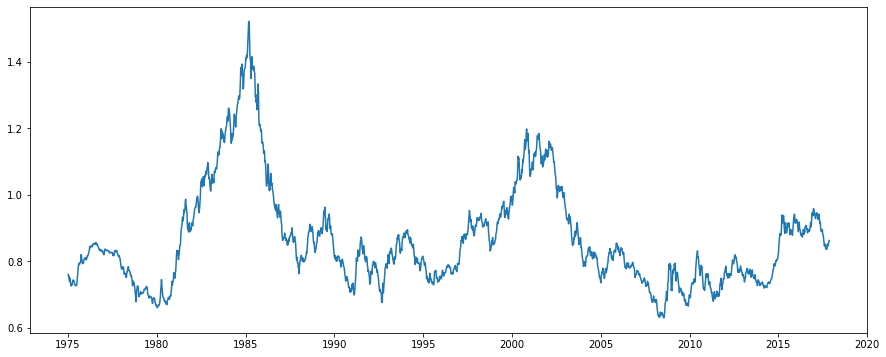

In [22]:
ts_week = ts.resample('W').mean()
print(ts_week.head())
plt.plot(ts_week)

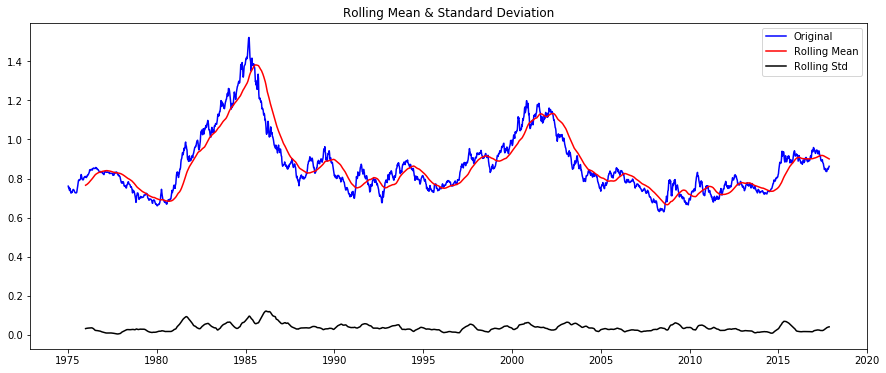

Results of Dickey-Fuller Test:
(-2.0763405999329847, 0.25413395509267644, 2, 2234, {'1%': -3.4332805415364724, '5%': -2.8628346299364282, '10%': -2.5674591931002038}, -14013.954809290073)
Test Statistic                   -2.076341
p-value                           0.254134
#Lags Used                        2.000000
Number of Observations Used    2234.000000
Critical Value (1%)              -3.433281
Critical Value (5%)              -2.862835
Critical Value (10%)             -2.567459
dtype: float64


In [23]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=52,center=False).mean() 
    rolstd = timeseries.rolling(window=52,center=False).std()
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    print(dftest)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
test_stationarity(ts_week)

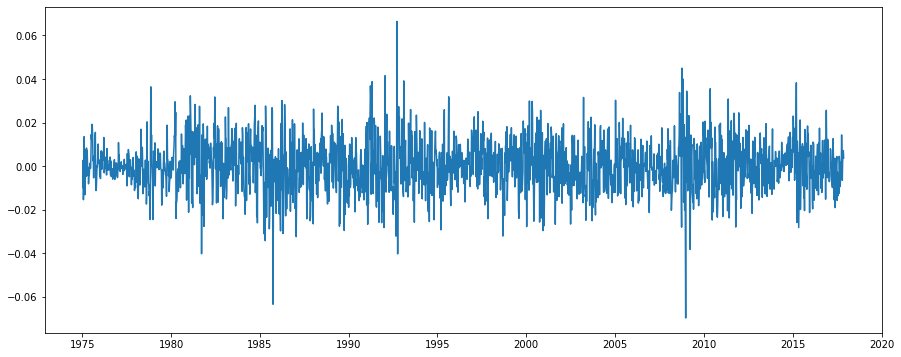

In [86]:
ts_week_log = np.log(ts_week)
ts_week_log_diff = ts_week_log - ts_week_log.shift()
plt.plot(ts_week_log_diff)

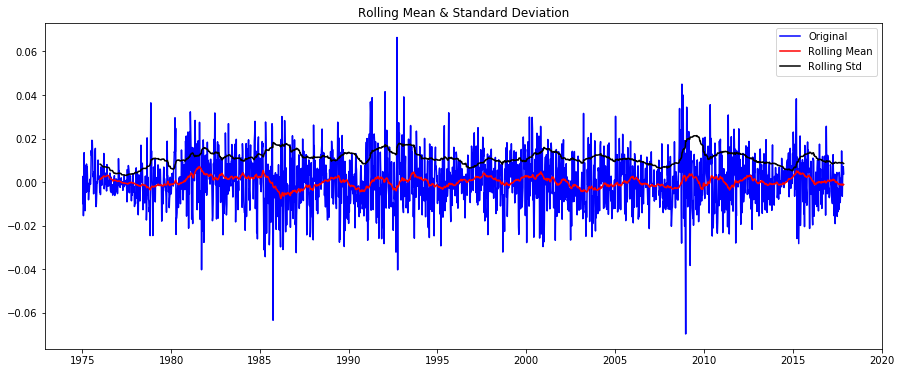

Results of Dickey-Fuller Test:
(-36.59000378316753, 0.0, 0, 2235, {'1%': -3.4332792288216227, '5%': -2.8628340503010357, '10%': -2.567458884484683}, -13550.085317810266)
Test Statistic                  -36.590004
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    2235.000000
Critical Value (1%)              -3.433279
Critical Value (5%)              -2.862834
Critical Value (10%)             -2.567459
dtype: float64


In [87]:
ts_week_log_diff.dropna(inplace=True)
test_stationarity(ts_week_log_diff)

In [88]:
#ACF and PACF
lag_acf = acf(ts_week_log_diff, nlags=10)
lag_pacf = pacf(ts_week_log_diff, nlags=10, method='ols')

C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


Text(0.5, 1.0, 'Autocorrelation Function')

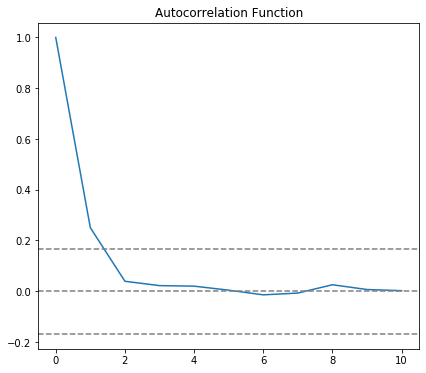

In [89]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_week_log_diff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_week_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

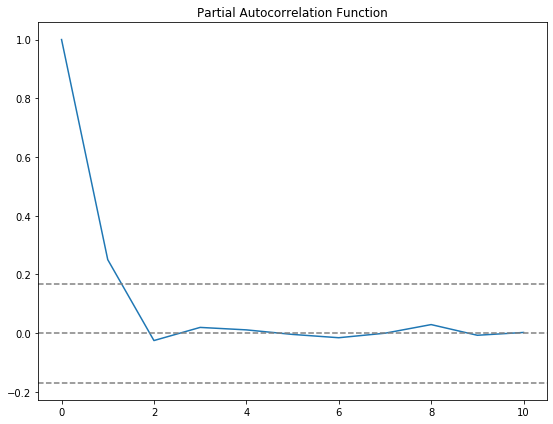

In [90]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_week_log_diff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_week_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

Text(0.5, 1.0, 'RSS: 0.2806')

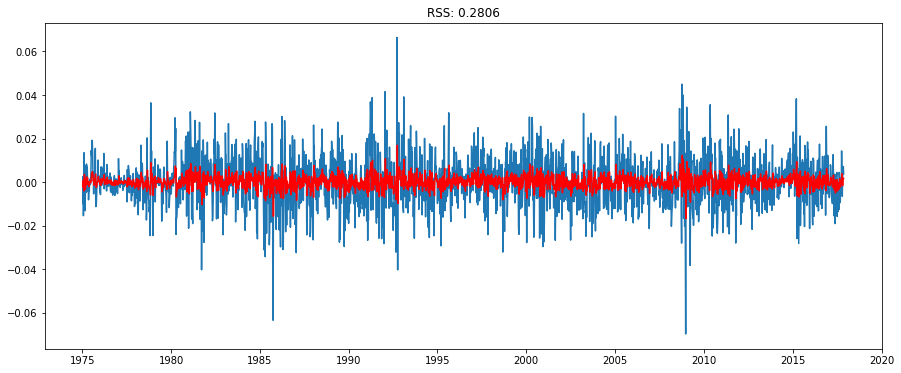

In [114]:
model = ARIMA(ts_week_log, order=(2, 1, 1))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_week_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_week_log_diff)**2))

                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                 2236
Model:                 ARIMA(2, 1, 1)   Log Likelihood                6870.601
Method:                       css-mle   S.D. of innovations              0.011
Date:                Thu, 23 Apr 2020   AIC                         -13731.202
Time:                        16:05:39   BIC                         -13702.640
Sample:                    01-12-1975   HQIC                        -13720.773
                         - 11-12-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           5.51e-05      0.000      0.178      0.859      -0.001       0.001
ar.L1.D.Value    -0.0901      0.487     -0.185      0.853      -1.044       0.864
ar.L2.D.Value     0.0602      0.128     

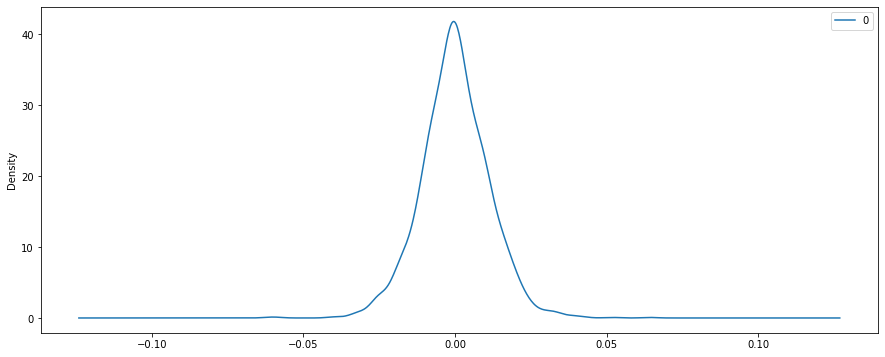

In [92]:
print(results_ARIMA.summary())
# plot residual errors
residuals = DataFrame(results_ARIMA.resid)
residuals.plot(kind='kde')
print(residuals.describe())

In [93]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print (predictions_ARIMA_diff.head())

Date
1975-01-12    0.000055
1975-01-19   -0.002420
1975-01-26    0.000987
1975-02-02   -0.004103
1975-02-09   -0.001134
Freq: W-SUN, dtype: float64


Text(0.5, 1.0, 'RMSE: 0.1353')

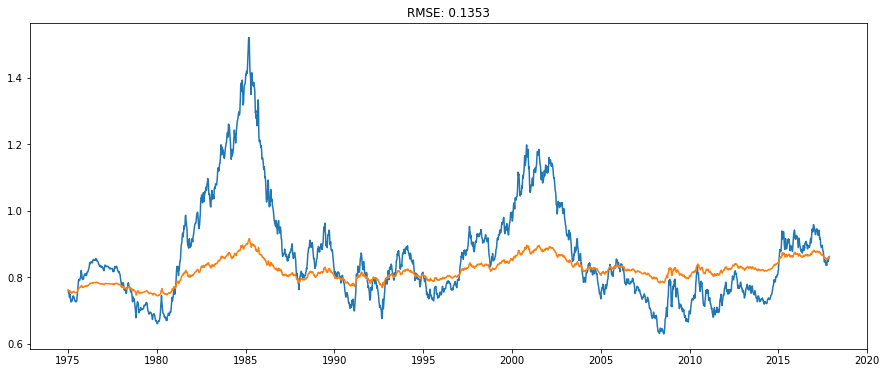

In [106]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(ts_week_log.iloc[0], index=ts_week_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts_week)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts_week)**2)/len(ts_week)))

In [95]:
size = int(len(ts_week_log) - 15)
train, test = ts_week_log[0:size], ts_week_log[size:len(ts_week_log)]
history = [x for x in train]
predictions = list()

In [109]:
size = int(len(ts_week_log) - 15)
train, test = ts_week_log[0:size], ts_week_log[size:len(ts_week_log)]
history = [x for x in train]
predictions = list()
print('Printing Predicted vs Expected Values...')
print('\n')
for t in range(len(test)):
    model = ARIMA(history, order=(2,1,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    obs = test[t]
    history.append(obs)
print('predicted=%f, expected=%f' % (np.exp(yhat), np.exp(obs)))

Printing Predicted vs Expected Values...


predicted=0.860853, expected=0.862600


In [97]:
error = mean_squared_error(test, predictions)
print('\n')
print('Printing Mean Squared Error of Predictions...')
print('Test MSE: %.6f' % error)
predictions_series = pd.Series(predictions, index = test.index)



Printing Mean Squared Error of Predictions...
Test MSE: 0.000043


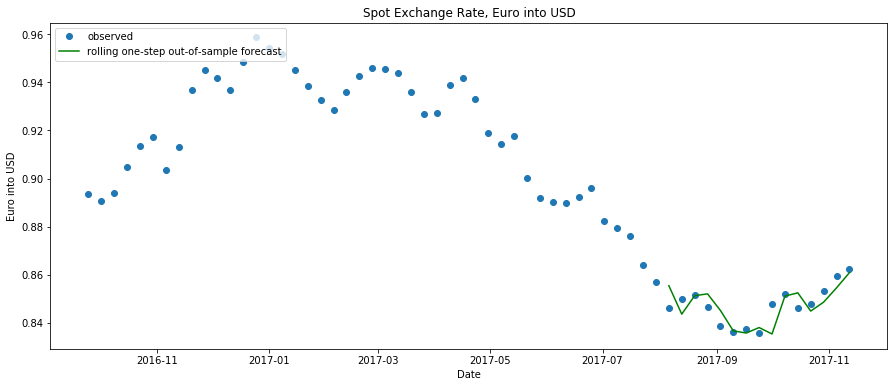

In [98]:
fig, ax = plt.subplots()
ax.set(title='Spot Exchange Rate, Euro into USD', xlabel='Date', ylabel='Euro into USD')
ax.plot(ts_week[-60:], 'o', label='observed')
ax.plot(np.exp(predictions_series), 'g', label='rolling one-step out-of-sample forecast')
legend = ax.legend(loc='upper left')
legend.get_frame().set_facecolor('w')

In [ ]:
#time series class recording part-1

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv(r'C:\Users\ADMIN\Desktop\WFH_HOL\CSV\airline_passengers.csv')
data.head()

,Month,Thousands of Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [3]:
#making month as datetime type
data.Month=pd.to_datetime(data['Month'])

In [4]:
#fixing index as month column
data.set_index('Month',inplace=True)

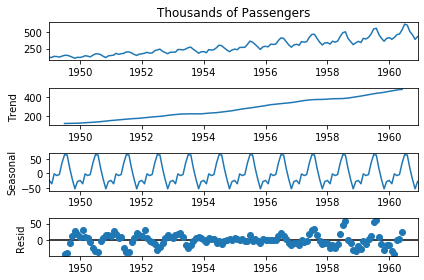

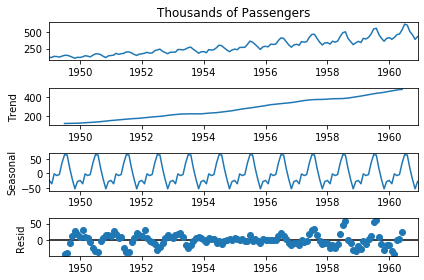

In [5]:
#finding diff components of TSA(trend,season,.....) using library
from statsmodels.tsa.seasonal import seasonal_decompose
decompo=seasonal_decompose(data['Thousands of Passengers'])
decompo.plot()

In [6]:
#dicky fuller test for checking stationarity 
from statsmodels.tsa.stattools import adfuller
adfuller(data['Thousands of Passengers'])
#second value is p-value(0.991880243437641) data is not stationarity

(0.8153688792060497,
 0.991880243437641,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 996.692930839019)

In [7]:
#coverting test result into redable format
def ADF_test(data):
    result=adfuller(data)
    print('Augumented Dicky Fullern Test')
    label=['ADF test statics','p-value','#lags','no of data']
    for i,j in zip(result,label):
        print(j + ':' + str(i))
    if result[1]<=0.05:
        print('Time Series is Stationary')
    else:
         print('Time Series is not Stationary')

In [8]:
ADF_test(data['Thousands of Passengers'])
#p-value is high

Augumented Dicky Fullern Test
ADF test statics:0.8153688792060497
p-value:0.991880243437641
#lags:13
no of data:130
Time Series is not Stationary


In [9]:
#doing differencing to make data as stationary
data['Thousands of Passengers 1st diff']=data['Thousands of Passengers']-data['Thousands of Passengers'].shift(1)
data.head()

,Thousands of Passengers,Thousands of Passengers 1st diff
Month,,
1949-01-01,112,NaN
1949-02-01,118,6.0
1949-03-01,132,14.0
1949-04-01,129,-3.0
1949-05-01,121,-8.0


In [10]:
#doing ADF test for the new data column
#for ADF test data should not contain NaN values 
ADF_test(data['Thousands of Passengers 1st diff'].dropna())
#again p-value is high

Augumented Dicky Fullern Test
ADF test statics:-2.8292668241699963
p-value:0.05421329028382592
#lags:12
no of data:130
Time Series is not Stationary


In [11]:
#doing differencing to make new data as stationary
data['Thousands of Passengers 2nd diff']=data['Thousands of Passengers 1st diff']-data['Thousands of Passengers 1st diff'].shift(1)
data.head()

,Thousands of Passengers,Thousands of Passengers 1st diff,Thousands of Passengers 2nd diff
Month,,,
1949-01-01,112,NaN,NaN
1949-02-01,118,6.0,NaN
1949-03-01,132,14.0,8.0
1949-04-01,129,-3.0,-17.0
1949-05-01,121,-8.0,-5.0


In [12]:
#doing ADF test for the new data column
#for ADF test data should not contain NaN values 
ADF_test(data['Thousands of Passengers 2nd diff'].dropna())
#p-value is low

Augumented Dicky Fullern Test
ADF test statics:-16.38423154246852
p-value:2.732891850014085e-29
#lags:11
no of data:130
Time Series is Stationary


In [15]:
# we used two time differencing So
#d-value=2

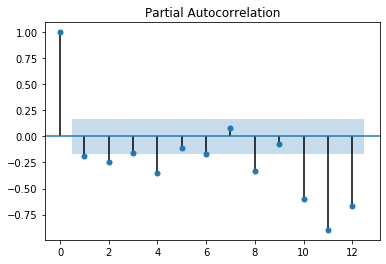

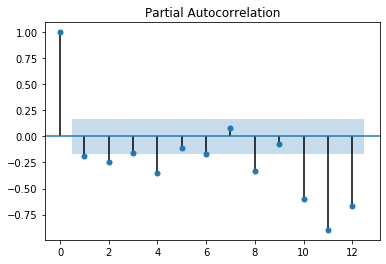

In [16]:
#finding p,q values using graphical method for trend
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
#lags=12 taking 12 past values to find p-values using pacf
plot_pacf(data['Thousands of Passengers 2nd diff'].dropna(),lags=12) 
#therer is no nearby correlation values for the past values
#p-value=0

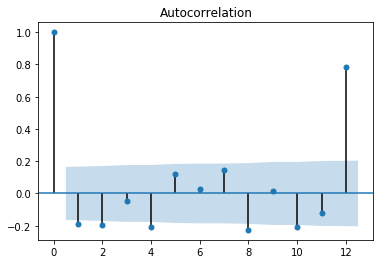

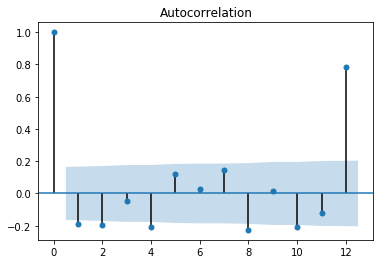

In [17]:
#lags=12 taking 12 past values to find p-values using acf
plot_acf(data['Thousands of Passengers 2nd diff'].dropna(),lags=12)
#1st is current data so therer is no nearby correlation values error
#q-value=0 

In [18]:
#class recording part-2
#finding P,Q,D values using graphical method for seasonality

In [20]:
#seasonal we took 1 year(12months) coz data used as a yearly data,So shift(12) it leaves 1st 12 values n do differencing
data['Seasonal Difference']=data['Thousands of Passengers']-data['Thousands of Passengers'].shift(12)
data

,Thousands of Passengers,Thousands of Passengers 1st diff,Thousands of Passengers 2nd diff,Seasonal Difference
Month,,,,
1949-01-01,112,NaN,NaN,NaN
1949-02-01,118,6.0,NaN,NaN
1949-03-01,132,14.0,8.0,NaN
1949-04-01,129,-3.0,-17.0,NaN
1949-05-01,121,-8.0,-5.0,NaN
...,...,...,...,...
1960-08-01,606,-16.0,-103.0,47.0
1960-09-01,508,-98.0,-82.0,45.0
1960-10-01,461,-47.0,51.0,54.0


In [21]:
#again checking the new data by ADF test
ADF_test(data['Seasonal Difference'].dropna())
#p<0.05 we did only one time differencing,So
#D=1

Augumented Dicky Fullern Test
ADF test statics:-3.3830207264924796
p-value:0.011551493085515008
#lags:1
no of data:130
Time Series is Stationary


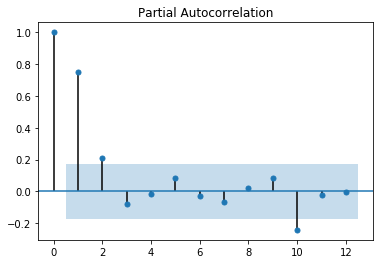

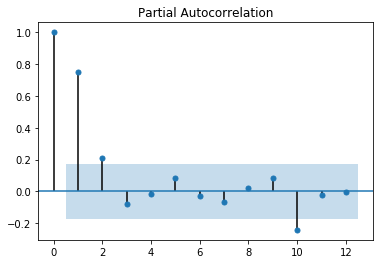

In [22]:
#finding P,Q values using graphical method for seasonality
#lags=12 taking 12months past values to find P-values using pacf
plot_pacf(data['Seasonal Difference'].dropna(),lags=12) 
#therer is only one nearby correlation values for the past values(1,0.7) is taken 
                    #(0.7,0.25) is not taken coz its not highly correlated
#P-value=1

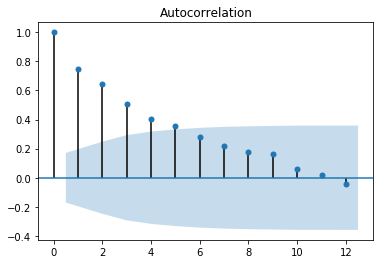

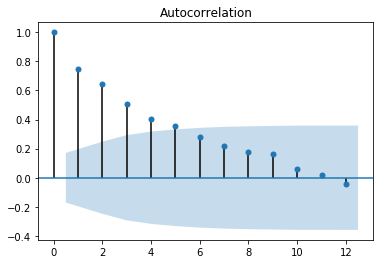

In [23]:
#lags=12 taking 12months past values to find Q-values using pacf
plot_acf(data['Seasonal Difference'].dropna(),lags=12) 
#there is three nearby correlation error values for the past values error coz we taken value only above (y) 0.5
#Q-value=3

In [ ]:
#ARIMA model(0,2,0)(1,1,3)
Example
#AR model(1,0,0)
#MA model(0,0,1)

In [24]:
#importing ARIMAS libraries
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

In [27]:
#orer(p,d,q)
#seasonal_order(P,D,Q,seaonal_value(we took 12months))
model=sm.tsa.statespace.SARIMAX(data['Thousands of Passengers'],orders=(0,2,0),seasonal_order=(1,1,3,12))
result=model.fit()
print(result.summary())
#here AIC,BIC VALUE is high it should be low for good model 

C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                         SARIMAX Results                                          
Dep. Variable:                    Thousands of Passengers   No. Observations:                  144
Model:             SARIMAX(1, 0, 0)x(1, 1, [1, 2, 3], 12)   Log Likelihood                -516.143
Date:                                    Tue, 19 May 2020   AIC                           1044.287
Time:                                            15:08:51   BIC                           1061.584
Sample:                                        01-01-1949   HQIC                          1051.315
                                             - 12-01-1960                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9473      0.030     31.457      0

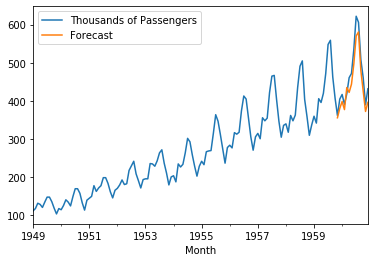

In [29]:
#predicting the value using model created
#it takes value from 130 to 144 rows
data['Forecast']=result.predict(start=130,end=144,dynamic=True)
#ploting the graph for pricted values n actual values
data[['Thousands of Passengers','Forecast']].plot()

In [30]:
#created model is not that much good
data

,Thousands of Passengers,Thousands of Passengers 1st diff,Thousands of Passengers 2nd diff,Seasonal Difference,Forecast
Month,,,,,
1949-01-01,112,NaN,NaN,NaN,NaN
1949-02-01,118,6.0,NaN,NaN,NaN
1949-03-01,132,14.0,8.0,NaN,NaN
1949-04-01,129,-3.0,-17.0,NaN,NaN
1949-05-01,121,-8.0,-5.0,NaN,NaN
...,...,...,...,...,...
1960-08-01,606,-16.0,-103.0,47.0,580.855715
1960-09-01,508,-98.0,-82.0,45.0,479.679736
1960-10-01,461,-47.0,51.0,54.0,425.195947


In [33]:
#manually changing oder,Seasonal_order values(permutation combination)
#orer(p,d,q)
#seasonal_order(P,D,Q,seaonal_value(we took 12months))
model=sm.tsa.statespace.SARIMAX(data['Thousands of Passengers'],orders=(0,1,0),seasonal_order=(1,2,2,12))
result=model.fit()
print(result.summary())
#here AIC,BIC VALUE is (low) it should be low for good model 

C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                        SARIMAX Results                                        
Dep. Variable:                 Thousands of Passengers   No. Observations:                  144
Model:             SARIMAX(1, 0, 0)x(1, 2, [1, 2], 12)   Log Likelihood                -472.839
Date:                                 Tue, 19 May 2020   AIC                            955.679
Time:                                         15:26:08   BIC                            969.616
Sample:                                     01-01-1949   HQIC                           961.339
                                          - 12-01-1960                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7609      0.080      9.471      0.000       0.603       0

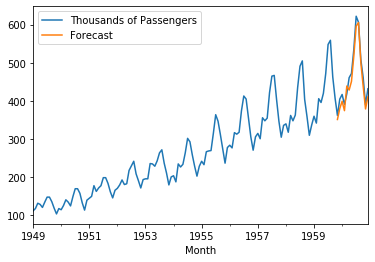

In [34]:
#predicting the value using model created
#it takes value from 130 to 144 rows and dynamically update values
data['Forecast']=result.predict(start=130,end=144,dynamic=True)
#ploting the graph for predicted values n actual values
data[['Thousands of Passengers','Forecast']].plot()

In [35]:
data

,Thousands of Passengers,Thousands of Passengers 1st diff,Thousands of Passengers 2nd diff,Seasonal Difference,Forecast
Month,,,,,
1949-01-01,112,NaN,NaN,NaN,NaN
1949-02-01,118,6.0,NaN,NaN,NaN
1949-03-01,132,14.0,8.0,NaN,NaN
1949-04-01,129,-3.0,-17.0,NaN,NaN
1949-05-01,121,-8.0,-5.0,NaN,NaN
...,...,...,...,...,...
1960-08-01,606,-16.0,-103.0,47.0,605.498327
1960-09-01,508,-98.0,-82.0,45.0,499.989478
1960-10-01,461,-47.0,51.0,54.0,438.030738


In [ ]:
#use autoARIMA code for finding best (p,d,q),(P,D,Q) and low AIC,BIC values

In [42]:
#predicting value for next two years
#creating next two years to the dataset from last 144th row date
from pandas.tseries.offsets import DateOffset
#2 years so month 24(range)
future_dates=[data.index[-1] + DateOffset(months=x) for x in range(24)]
future_dates

[Timestamp('1960-12-01 00:00:00'),
 Timestamp('1961-01-01 00:00:00'),
 Timestamp('1961-02-01 00:00:00'),
 Timestamp('1961-03-01 00:00:00'),
 Timestamp('1961-04-01 00:00:00'),
 Timestamp('1961-05-01 00:00:00'),
 Timestamp('1961-06-01 00:00:00'),
 Timestamp('1961-07-01 00:00:00'),
 Timestamp('1961-08-01 00:00:00'),
 Timestamp('1961-09-01 00:00:00'),
 Timestamp('1961-10-01 00:00:00'),
 Timestamp('1961-11-01 00:00:00'),
 Timestamp('1961-12-01 00:00:00'),
 Timestamp('1962-01-01 00:00:00'),
 Timestamp('1962-02-01 00:00:00'),
 Timestamp('1962-03-01 00:00:00'),
 Timestamp('1962-04-01 00:00:00'),
 Timestamp('1962-05-01 00:00:00'),
 Timestamp('1962-06-01 00:00:00'),
 Timestamp('1962-07-01 00:00:00'),
 Timestamp('1962-08-01 00:00:00'),
 Timestamp('1962-09-01 00:00:00'),
 Timestamp('1962-10-01 00:00:00'),
 Timestamp('1962-11-01 00:00:00')]

In [41]:
#creating new data frame for next two years with column that was taken from given dataset 
future_dates_df=pd.DataFrame(index=future_dates[1:],columns=data.columns)
future_dates_df

,Thousands of Passengers,Thousands of Passengers 1st diff,Thousands of Passengers 2nd diff,Seasonal Difference,Forecast
1961-01-01,NaN,NaN,NaN,NaN,NaN
1961-02-01,NaN,NaN,NaN,NaN,NaN
1961-03-01,NaN,NaN,NaN,NaN,NaN
1961-04-01,NaN,NaN,NaN,NaN,NaN
1961-05-01,NaN,NaN,NaN,NaN,NaN
1961-06-01,NaN,NaN,NaN,NaN,NaN
1961-07-01,NaN,NaN,NaN,NaN,NaN
1961-08-01,NaN,NaN,NaN,NaN,NaN
1961-09-01,NaN,NaN,NaN,NaN,NaN
1961-10-01,NaN,NaN,NaN,NaN,NaN


In [43]:
#concat(comining) two df with same column
future_df=pd.concat([data,future_dates_df])
future_df
#this df has both has given given values and created dates also

,Thousands of Passengers,Thousands of Passengers 1st diff,Thousands of Passengers 2nd diff,Seasonal Difference,Forecast
1949-01-01,112,NaN,NaN,NaN,NaN
1949-02-01,118,6.0,NaN,NaN,NaN
1949-03-01,132,14.0,8.0,NaN,NaN
1949-04-01,129,-3.0,-17.0,NaN,NaN
1949-05-01,121,-8.0,-5.0,NaN,NaN
...,...,...,...,...,...
1962-07-01,NaN,NaN,NaN,NaN,NaN
1962-08-01,NaN,NaN,NaN,NaN,NaN
1962-09-01,NaN,NaN,NaN,NaN,NaN
1962-10-01,NaN,NaN,NaN,NaN,NaN


C:\Users\ADMIN\anaconda3\lib\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2014: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  ' effect.', ValueWarning)


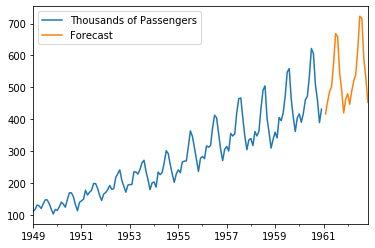

In [45]:
#predicting values for new dates by using model we created
#it takes value from 145 to 167 rows and dynamically update values
future_df['Forecast']=result.predict(start=145,end=167,dynamic=True)
#ploting the graph for actual values along with predicted new values
future_df[['Thousands of Passengers','Forecast']].plot()

In [46]:
#dataset with next 2 yrs prediction values
future_df

,Thousands of Passengers,Thousands of Passengers 1st diff,Thousands of Passengers 2nd diff,Seasonal Difference,Forecast
1949-01-01,112,NaN,NaN,NaN,NaN
1949-02-01,118,6.0,NaN,NaN,NaN
1949-03-01,132,14.0,8.0,NaN,NaN
1949-04-01,129,-3.0,-17.0,NaN,NaN
1949-05-01,121,-8.0,-5.0,NaN,NaN
...,...,...,...,...,...
1962-07-01,NaN,NaN,NaN,NaN,722.899043
1962-08-01,NaN,NaN,NaN,NaN,716.533371
1962-09-01,NaN,NaN,NaN,NaN,589.285389
1962-10-01,NaN,NaN,NaN,NaN,529.082850
